In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [4]:
#read data from the files
def read_data():
    #Reading the movies data from file movie.csv
    df_movies =  pd.read_csv('movies.csv',usecols=['movieId','title'],dtype={'movieId':'int32','title':'str'})
    
    #Reading the ratings for each movie by all the users from ratings.csv
    df_ratings = pd.read_csv('ratings.csv',usecols=['userId','movieId','rating'],dtype={'userId':'int32','movieId':'int32','rating':'float32'})

    return df_movies,df_ratings

In [5]:
def data_stats(df_movies,df_ratings):

    #calculating the no of ratings for each movieId
    freqOfRatings=list()
    movieIds=list()

    for i in df_movies['movieId']:
        freqOfRatings.append(float(df_ratings[df_ratings.movieId==i].shape[0]))

    movieIds = list(range(0,len(df_movies)))

    #print(freqOfRatings)
    #plotting the rating frequency of all movies

    plt.figure()
    plt.plot(movieIds,freqOfRatings,linestyle='-')
    plt.xlabel('movie Id')
    plt.ylabel('numbers of ratings')
    plt.title('Frequency of all movies')
    plt.show()

In [6]:
def preprocess_data(df_ratings):

    #pivot ratings into movie features
    #here we'll transform the dataset into a matrix where column will represent a user and row is a movie.
    #Also each value M[i,j]=x , where x is the rating given by a user j to a movie i.
    df_movie_features = df_ratings.pivot(index='movieId',columns='userId',values='rating').fillna(0)

    #convert dataframe of movie features to scipy sparse matirx
    mat_movie_features = csr_matrix(df_movie_features.values)
    #here we have used the scipy spares matrix because there will be many entries of 0 in the matrix,
    #thus to make the calculation efficient and less memory footprint.
    
    return df_movie_features.to_numpy()

In [7]:
def initalize_parameters(no_of_movies,no_of_users,no_of_features=100):
    #First we initalize a matrix which which containt the feature set of each movie.
    #This feature set will help us during collaborative filtering to judge the movie rating by a user.
    X = np.random.randn(no_of_movies,no_of_features)
    
    #Next we create a matrix theta which will govern the interest of a specific user on a specific movie feature.
    theta = np.random.randn(no_of_users,no_of_features)
    
    parameters ={
        "X":X,
        "theta":theta
    }
    
    return parameters

In [19]:
def compute_cost(parameters,r_matrix,mat_movie_ratings,lamda):
    
    X = parameters["X"]
    theta = parameters["theta"]
    
    cst = (np.multiply(np.dot(X,theta.T),r_matrix) - mat_movie_ratings)
    cost = np.sum(np.multiply(cst,cst))/2 + (np.sum(np.multiply(X,X)) + np.sum(np.multiply(theta,theta)))*(lamda/2)
    
    return cost

In [16]:
def grad(parameters,r_matrix,Y,learning_rate,lamda,num_of_iters=1500):
    
    
    cost_lst = list()
    for j in range(0,num_of_iters):
        
        #computing the cost
        cost = compute_cost(parameters,r_matrix,Y,lamda)
        
        #Computing the gradients
        #theta_temp = parameters["theta"]
        #dX = np.dot((np.multiply(np.dot(parameters["X"],parameters["theta"].T),r_matrix) - Y),parameters["theta"])
        #dtheta = np.dot((np.multiply(np.dot(parameters["X"],parameters["theta"].T),r_matrix) - Y).T,parameters["X"])
        
        X = parameters["X"]
        theta = parameters["theta"]
        dX = np.zeros(X.shape)
        dtheta = np.zeros(theta.shape)
        
        #In this for loop, we compute the matrix dX for the gradient descent step of X
        #In order to implement collaborative filtering, we compute gradient only for those X for which we have a
        # rating defined!
        for i in range(0,X.shape[0]):
            lst = tuple(np.where(r_matrix[i,:]==1))
            theta_temp = theta[tuple(lst),:]
            theta_temp = np.reshape(theta_temp,(theta_temp.shape[1],theta_temp.shape[2]))
            y_temp = Y[i,tuple(lst)]
            dX[i,:] = np.dot((np.dot(X[i,:],theta_temp.T)-y_temp),theta_temp)
        
        #In this for loop, we compute the matrix dtheta for the gradient descent step of theta
        for i in range(0,theta.shape[0]):
            lst = tuple(np.where(r_matrix[:,i]==1))
            X_temp = X[tuple(lst),:]
            y_temp = Y[tuple(lst),i]
            dtheta[i,:] = np.dot((np.dot(X_temp,theta[i,:])-y_temp),X_temp)
            
            
        #Performing gradient descendt step
        parameters["X"] = parameters["X"] - learning_rate*(dX + lamda*X)
        parameters["theta"] = parameters["theta"] - learning_rate*(dtheta + lamda*theta)
        
        cost_lst.append(cost)
        if( j%100 == 0):
            print("Cost after ietration {} is {}".format(j,cost))
            
            
    plt.figure()
    plt.plot(list(range(0,num_of_iters)),cost_lst)
    plt.xlabel("Number of Iterartions")
    plt.ylabel("Cost")
    plt.title("Cost Vs. Iterations")
    plt.show()
    
    return parameters

In [26]:
def model():
    
    #First of all we'll load the data into the variables
    df_movies,df_ratings=read_data()
    
    #View the data
    df_movies.head(5)
    df_ratings.head(5)
    
    #We'll then compute some stats over the data
    data_stats(df_movies,df_ratings)
    
    
    #The next step is to preprocess the data.
    #In order to make the data usable we convert it into the required metrix form and perform Normalization if needed.
    mat_movie_ratings = preprocess_data(df_ratings)
    print("The total number of movies are: {}".format(mat_movie_ratings.shape[0]))
    print("The total number of users are: {}".format(mat_movie_ratings.shape[1]))
    
    #After preprocessing the data, we'll initalize the parameters to implement collaborative filtering
    #We will use two parameters - X (to describe the feature set of each movie)
    #                             theta (to describe the interest of each user for each feature that governs a movie)
    #Thus, in X matrix, an ith row will correspond to the feature vector of some ith movie
    #Similiarly in theta matrix, a jth row will correspond to the interest of jth user in the feature set that governs the movie.
    parameters = initalize_parameters(mat_movie_ratings.shape[0],mat_movie_ratings.shape[1],100)
    
    #Now we'll form a R matrix with only 1's and 0's which will work as a logical matrix while computing cost.
    r_matrix = mat_movie_ratings.copy().astype(bool)
    r_matrix = r_matrix.astype(int)
    
    
    #After initalizing the parameters randomly, we'll now learn the parameters according to the data present with us.
    #For the sake of this, we'll implement simple gradient learning algorithm to train the parameters.
    parameters = grad(parameters,r_matrix,mat_movie_ratings,learning_rate=0.0007,lamda=1.5,num_of_iters=5000)
    
    return parameters

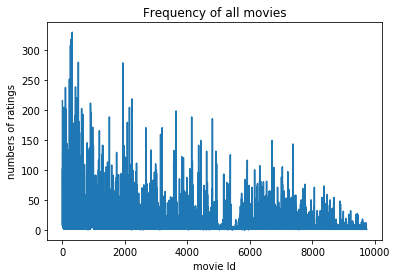

The total number of movies are: 9724
The total number of users are: 610
Cost after ietration 0 is 6521775.525157361
Cost after ietration 100 is 622805.2022430801
Cost after ietration 200 is 496458.48758458404
Cost after ietration 300 is 403571.35463518865
Cost after ietration 400 is 329670.0503945877
Cost after ietration 500 is 269991.49193670886
Cost after ietration 600 is 221601.56791957037
Cost after ietration 700 is 182325.53344051
Cost after ietration 800 is 150461.69673047573
Cost after ietration 900 is 124643.49201679321
Cost after ietration 1000 is 103754.34989450214
Cost after ietration 1100 is 86874.22537724706
Cost after ietration 1200 is 73245.3758514799
Cost after ietration 1300 is 62247.4891277468
Cost after ietration 1400 is 53375.21746364374
Cost after ietration 1500 is 46217.28319296332
Cost after ietration 1600 is 40439.10879028682
Cost after ietration 1700 is 35769.69688706227
Cost after ietration 1800 is 31991.233119006556
Cost after ietration 1900 is 28929.61279264

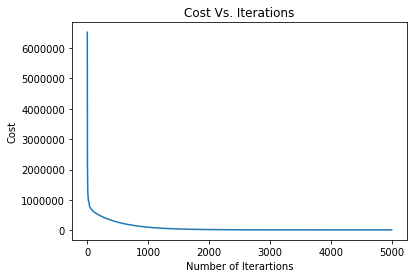

In [27]:
parameters = model()

In [82]:
def predict(parameters,df_movies):
    X = parameters["X"]
    theta = parameters["theta"]
    
    mat = np.dot(X,theta.T)
    print("The user ids are in the range [0,609]")
    
    try:
        i = int(input("Enter the userId for which you want to know the reommendations:-"))
    except:
        print("Enter a valid User Id")
        predict(parameters,df_movies)
        return

    lst=list()
    print("Recommendations for User {}".format(i))
    print("Movie Name")
    for j in range(0,mat.shape[0]):
        if(mat[j][i] >=4):
            string=list(df_movies[df_movies['movieId']==j]['title'])
            if(len(string)>0 and mat[j][i]<=5):
                print("{}".format(string))
                print("Predicted rating : {}".format(mat[j][i]))

In [83]:
df_movies,df_ratings = read_data()

In [84]:
predict(parameters,df_movies)

The user ids are in the range [0,609]
Enter the userId for which you want to know the reommendations:-400
Recommendations for User 400
Movie Name
['How to Make an American Quilt (1995)']
Predicted rating : 4.007116959148574
['Unstrung Heroes (1995)']
Predicted rating : 4.230297063301359
['Specialist, The (1994)']
Predicted rating : 4.029808326721662
['Robin Hood: Men in Tights (1993)']
Predicted rating : 4.179695741755024
['House Arrest (1996)']
Predicted rating : 4.0875631040111395
['Carpool (1996)']
Predicted rating : 4.092823299102455
['Affair to Remember, An (1957)']
Predicted rating : 4.045520494490909
['Glory (1989)']
Predicted rating : 4.21063562065738
['Jackie Brown (1997)']
Predicted rating : 4.2910637930618165
["Buffalo '66 (a.k.a. Buffalo 66) (1998)"]
Predicted rating : 4.023100104793899
['Rawhead Rex (1986)']
Predicted rating : 4.0106545875301185
['Music of the Heart (1999)']
Predicted rating : 4.281788402070865
['Down to You (2000)']
Predicted rating : 4.114012983118933
['